# Working with the `Host` Class

Similar to the [transient_objects.ipynb](./transient_objects.ipynb) notebook, this will go through useful methods of the `Host` class. The general thing to keep in mind here is that we want to minimize the amount of data that 
OTTER stores locally for Hosts. This is because much of the data is already available in an easy format online. So, instead, we provide code to query those services for data on the hosts and just store host metadata.

We will start by setting up the OTTER dataset connection and pulling the Host information from the ASASSN-14li Transient object. If you are unsure what this means, we recommend you return to the [transient_objects.ipynb](./transient_objects.ipynb) notebook.

In [1]:
# imports
import os
import otter
import matplotlib.pyplot as plt

In [2]:
# THIS IS WHAT YOU CHANGE IF YOU HAVE THE DATA IN A DIFFERENT PATH
otterpath = os.path.join(os.environ['OTTER_DATA_DIR']) 

# connect to the dataset
db = otter.Otter(otterpath)
summary = db.generate_summary_table(save=True)

# grab the host information for ASASSN-14li
t = db.query(names='ASASSN-14li')[0]
host = t.get_host()[0] # we can just take the last one

host

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


SDSS J124815.23+174626.4 @ (RA, Dec)=(192.06249999999997 deg,17.77401111111111 deg)

Before we do anything else, let's take a look at the host attributes and methods with the documentation. The notable attributes are:
* `name`: The name of the host
* `coord`: The astropy SkyCoord for this host
* `z` or `redshift`: The redshift of this host
* `transient_name`: The default name from OTTER for the associated transient
* `bibcodes`: The references that say this is the host galaxy of `transient_name`

In [3]:
help(host)

Help on Host in module otter.io.host object:

class Host(otter.io.data_finder.DataFinder)
 |  Host(host_ra: 'str | float', host_dec: 'str | float', host_ra_units: 'str | u.Unit', host_dec_units: 'str | u.Unit', host_name: 'str' = None, host_redshift: 'float' = None, reference: 'list[str]' = None, transient_name: 'str' = None, **kwargs) -> 'None'
 |  
 |  Method resolution order:
 |      Host
 |      otter.io.data_finder.DataFinder
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, host_ra: 'str | float', host_dec: 'str | float', host_ra_units: 'str | u.Unit', host_dec_units: 'str | u.Unit', host_name: 'str' = None, host_redshift: 'float' = None, reference: 'list[str]' = None, transient_name: 'str' = None, **kwargs) -> 'None'
 |      Object to store host information and query public data sources of host galaxies
 |      
 |      Subclass of the data scraper class to allow for these queries to happen
 |      
 |      Args:
 |          host_ra (str|float) : The

So, as you can see, this has many methods to pull data from a wide variety of sources for this host galaxy! I will go through three here; querying simbad, ZTF forced photometry, and sparcl (for spectra).

#### Simbad

Querying simbad will give you more meta information on the host, in case we are missing any in OTTER.

In [4]:
host.query_simbad()

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
NVSS J124815+174629,12 48 15.221,+17 46 26.35,7,7,833.000,833.000,90,C,R,2015ApJ...801...26H,1
LEDA 43234,12 48 15.2253,+17 46 26.475,14,14,0.171,0.108,90,A,O,2020yCat.1350....0G,1


#### ZTF Forced Photometry

The `query_ztf` method will pull all of the ZTF forced photometry for this Host. There are other services that will give you forced photometry like the `query_asassn`, `query_ptf`, and `query_atlas` methods. Most of these are easy and do not require authentication. But, please note, you need to set some special environment variables for querying ATLAS forced photometry.

In [5]:
ztf_phot = host.query_ztf()
ztf_phot

oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,chi,sharp,filefracday,field,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
int64,int32,float64,float64,float32,float32,int32,object,float64,float64,float32,float32,int64,int32,uint8,uint8,float32,float32,float32,float32,float32,float32,float32,int32
577108400005378,44831063,2458202.8161852155,58202.3106366,16.37723,0.014992147,0,zg,192.063438,17.7740715,2.716,0.277,20180325310625,577,8,4,20.85,26.241505,0.0337535,-0.024271995,4.0729796e-05,30.0,1.072,1
577108400005378,44833559,2458202.841138935,58202.3355903,16.419819,0.015127178,0,zg,192.0634047,17.7740339,2.877,0.218,20180325335579,577,8,4,20.9,26.23738,0.03151846,-0.021219717,3.6010155e-05,30.0,1.042,1
577108400005378,45130554,2458205.811087029,58205.305544,16.422834,0.015137038,0,zg,192.0634317,17.7740395,2.272,0.102,20180328305521,577,8,4,20.21,26.258638,0.040733323,-0.019816667,8.143837e-05,30.0,1.067,1
577108400005378,45131854,2458205.824084676,58205.3185417,16.42617,0.015148,0,zg,192.0634323,17.7740673,2.819,0.159,20180328318530,577,8,4,20.3,26.264067,0.041553747,-0.01758011,8.442703e-05,30.0,1.05,1
577108400005378,45629962,2458210.805131635,58210.2996296,16.441822,0.015200076,0,zg,192.0634537,17.7740789,1.981,0.149,20180402299468,577,8,4,19.75,26.169762,0.04299412,-0.008474942,0.00015637281,30.0,1.056,1
577108400005378,45632116,2458210.826670778,58210.321169,16.468002,0.015289681,32768,zg,192.0634521,17.7740457,1.635,0.101,20180402321157,577,8,4,19.27,26.04908,0.049283765,-0.020842288,0.0003108623,30.0,1.037,1
577108400005378,46028217,2458214.7876171353,58214.2821759,16.390034,0.015031914,0,zg,192.0633939,17.7741309,2.509,0.032,20180406282164,577,8,4,20.37,25.73719,0.04760029,-0.011636164,0.00010886254,30.0,1.065,1
577108400005378,47329508,2458227.8001540815,58227.295081,16.373016,0.014979218,0,zg,192.0633978,17.7740765,2.409,0.065,20180419295069,577,8,4,21.0,26.226395,0.032994743,-0.01994036,3.9443865e-05,30.0,1.034,1
577108400005378,47633460,2458230.839557638,58230.3346065,16.440844,0.015196787,0,zg,192.0634178,17.7740803,3.118,0.266,20180422334595,577,8,4,21.69,26.210157,0.025991382,-0.04899406,2.3768815e-05,30.0,1.082,1


Which gives us a lot of time-series photometry for this host! Let's plot the light curve, color coded by the filter. And, we can easily add a line for the discovery date of ASASSN-14li.

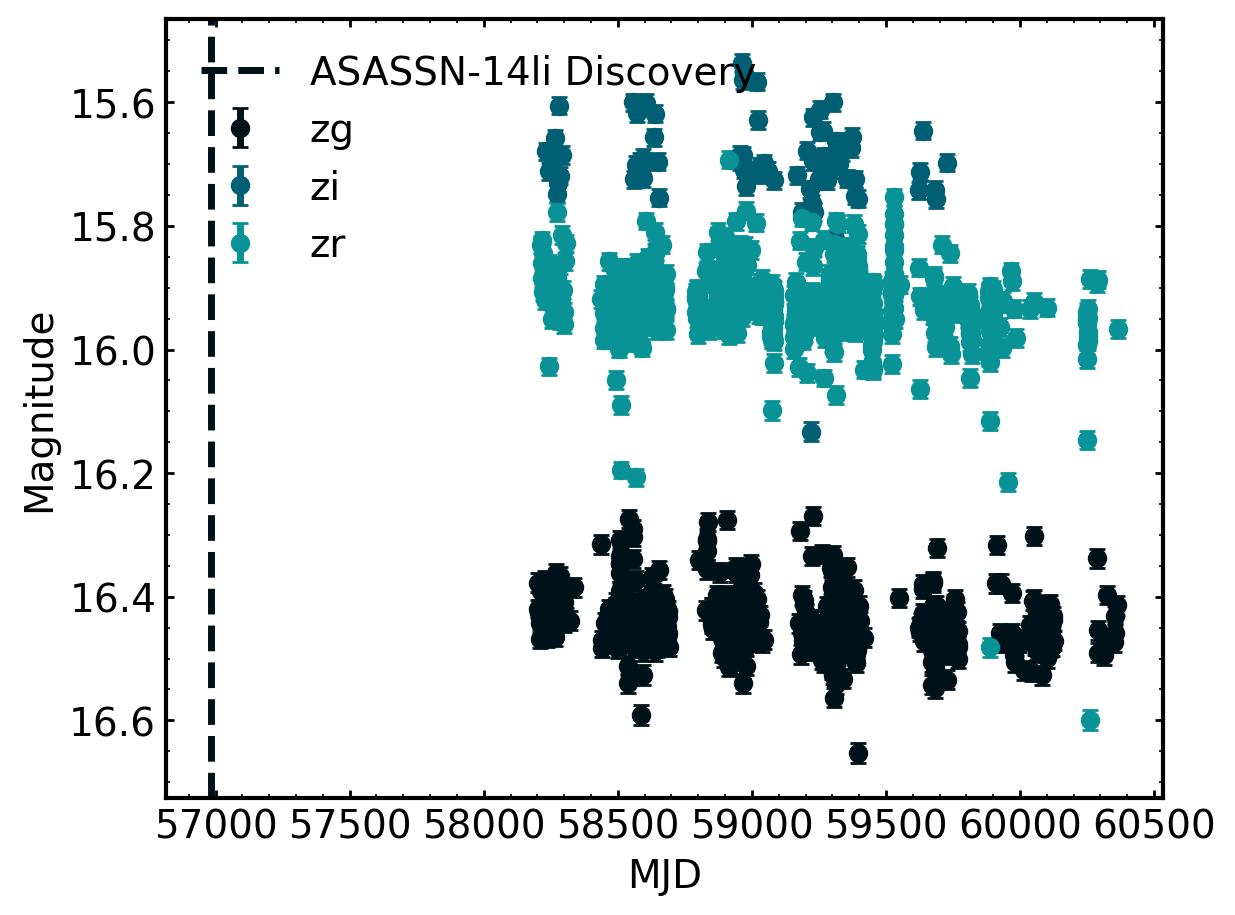

In [6]:
fig, ax = plt.subplots()
for label, grp in ztf_phot.to_pandas().groupby('filtercode'):
    ax.errorbar(grp.mjd, grp.mag, yerr=grp.magerr, fmt='o', label=label)

ax.axvline(t.get_discovery_date().mjd, linestyle='--', label='ASASSN-14li Discovery')
    
ax.set_ylabel('Magnitude')
ax.set_xlabel('MJD')
fig.gca().invert_yaxis()
ax.legend();

#### Get Host Spectra

To get host spectra, we use the `query_sparcl` method which queries the [SPARCL database](https://astrosparcl.datalab.noirlab.edu/). This will give an astropy table with columns for the wavelength and flux. 

For a description of the columns see [https://astrosparcl.datalab.noirlab.edu/sparc/sfc/](https://astrosparcl.datalab.noirlab.edu/sparc/sfc/)

In [8]:
spec = host.query_sparcl()
spec

specid,dec,sparcl_id,ra,wavelength,flux,_dr
int64,float64,str36,float64,object,object,str9
2928594919838738432,17.774016,8aa3ea9d-a072-11ee-870c-525400ad1336,192.06346,[3803.64520329 3804.5211258 3805.39725003 ... 9215.09888735 9217.22098659\n 9219.34357452],[75.78482819 75.77787018 78.90979004 ... 78.68370819 81.32446289\n 81.32581329],SDSS-DR16


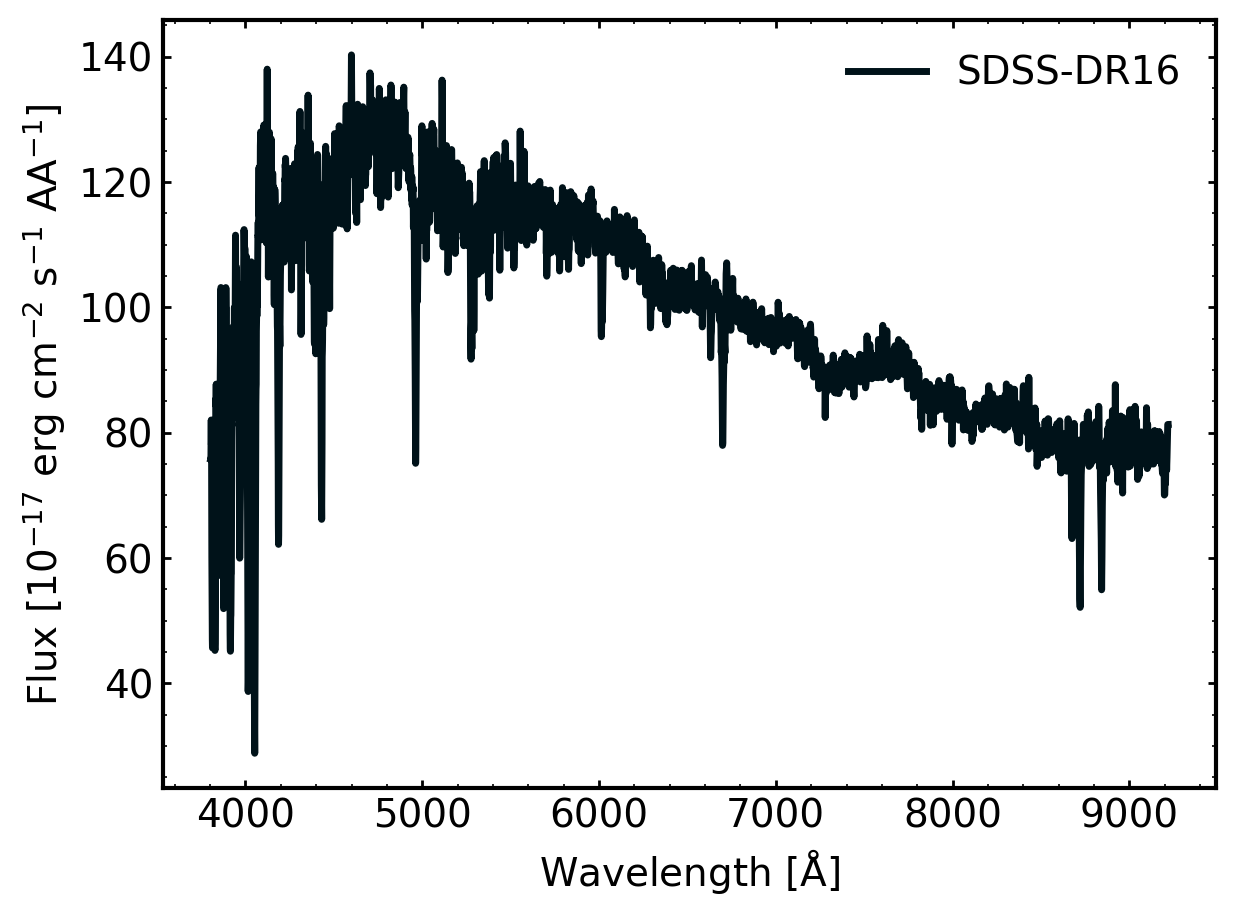

In [9]:
fig, ax = plt.subplots()

for row in spec:
    ax.plot(row['wavelength'], row['flux'], label=row['_dr'])
    
ax.set_ylabel(r'Flux [$10^{-17}~erg~cm^{-2}~s^{-1}~AA^{-1}$]')
ax.set_xlabel(r'Wavelength [$\AA$]')
ax.legend();